In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf 
import math as m


# more libraries required
from sklearn.preprocessing import OneHotEncoder, normalize, MinMaxScaler

import recommender_v4_1 as v4_1

Uploading data

In [ ]:
#backdated data
file_path = "C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/Rot3 AA/Recommender phase 2/datasets/backtesting/carnpar_202404_sample"
df_x =  pd.read_csv(file_path)
df_x = df_x[[col for col in df_x.columns if col != 'pol_type_desc'] + ['pol_type_desc']]


#current data
file_path = "C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/Rot3 AA/Recommender phase 2/datasets/backtesting/carnpar_current"
df_c =  pd.read_csv(file_path) #up-to-date data
df_c = df_c[[col for col in df_c.columns if col != 'pol_type_desc'] + ['pol_type_desc']]



In [ ]:
#preparing data for recommender
pol_columns_x,cat_col_x, Dx,id_col = v4_1.prep(df_x.copy())
pol_columns_c,cat_col_c, Dc,id_col = v4_1.prep(df_c)



For looking at one step size across folds

In [ ]:
recs = 6 #number of recommendations wanted
k=1 #how many folds for training
step_size = 1.68 #step size for the gradient descent

#Note: fold size and optimization fold size can be specified but the default is 10k and 1k respectively)

df_new,cw_weightings,jw_weightings,scores = v4_1.k_folds_optimization(df_x,k,Dx,Dc,recs,step_size,'other') #last fold's dataframe, different fold's weigthings, different fold's scores

In [7]:
scores

[0.5615986099044309]

In [ ]:
def gradient_descent_ss( cw, jw,pol_columns_r,cat_col_r,Rx,Dx,Dc,id_col,step):
    recs_df = v4_1.recommender(6, cw, jw,pol_columns_r,cat_col_r,Rx.copy())
    pids = recs_df[id_col].drop_duplicates() #pids that have recommendations, training pids

    df_new = v4_1.backtesting(Dx,Dc,pids,id_col,recs_df) #backtesting on the current fold

    mod_score = np.mean(df_new['MRR_4_score'])
    del df_new
    
    loss_step = v4_1.gradient(cw,jw,step,Rx, pol_columns_r, cat_col_r, id_col,Dx,Dc,pids) #loss for each weighting
    d_loss = loss_step - np.full_like(loss_step, 1- mod_score)#differnce in loss

    cw_next = cw - d_loss[0:len(cw)]
    jw_next = jw - d_loss[len(cw):]
    
    return cw_next, jw_next, np.linalg.norm(d_loss), mod_score



'''runs k folds of training sets (some sample of backdated data) through recommender, and backtests each'''
def k_folds_optimization_e_eval(df_x,k,Dx,Dc,t,step):

    #training data (subset of backdated data)
    pol_columns_r,cat_col_r, Rx,id_col = v4_1.prep(df_x.copy().drop(columns = ['businessentityname', 'trn_grp_desc', 'prod_house_desc',
           'prod_tbl_grp_desc', 'psm_opt_desc',  'sky_pol_type_desc', 'product_desc', 'prod_tbl_cd', 'pa_sts_desc','business_only_indicator', 
           'death_benefit_indicator','pps_full_flag'])) 
    #pol_columns_r,cat_col_r, Rx,id_col = prep(df_x.copy())
    #columns dropped because of previous model's target leakage, but model performs better without these columns...
    #Maybe investigate effect of keeping/dropping certain columns

    Rx = Rx.drop(columns = ['pol_count','no unique products','set of policies']).set_index(id_col)
    
    score_steps_ave = np.array([0]*t)
    fold_steps_ave = np.array([0]*t)
    for i in range(k):
        e = 0.1 #error value for gradient descent
        tk = t #to avoid infinite loop
        #step = 3 #update step for weightings

        Rx_s = Rx.copy().sample(1000) #the fold of data used for optimization

        cw = (1)*np.array([1] *(Rx_s.shape[1] -cat_col_r)) 
        jw = (1)*np.array([1] *(cat_col_r)) #include policy info

        #--------------------optimizations of weightings------------------

        fold_scores = []
        fold_loss = []
        while tk>0: #as e tend to zero the change in the "loss" value tends to zero
            cw,jw,e,score = gradient_descent_ss(cw,jw,pol_columns_r,cat_col_r,Rx_s,Dx,Dc,id_col,step) 
            fold_scores.append(score)
            fold_loss.append(e)
            tk = tk-1 
        score_steps_ave = np.add(score_steps_ave,fold_scores)
        fold_steps_ave = np.add(fold_steps_ave,fold_loss)


        #------------------------------------------------------------------------
    score_steps_ave = score_steps_ave/k
    fold_steps_ave = fold_steps_ave/k
    return score_steps_ave, fold_steps_ave

'''returns the average score and average fold loss for all folds over each step'''



'returns the average score and average fold loss for all folds over each step'

In [ ]:
steps = [1.67,1.68, 1.69]#steps to iterate through
t = 100 #number of iterations
step_scores = {} #the score for each step (average over folds)
step_losses = {} #the average of the updates made to the weightings at each step (average over folds)
k = 2 #number of folds
for step in steps:
    score_steps_ave, fold_steps_ave = k_folds_optimization_e_eval(df_x,k,Dx,Dc,t,step)
    step_scores[step] = score_steps_ave
    step_losses[step] = fold_steps_ave

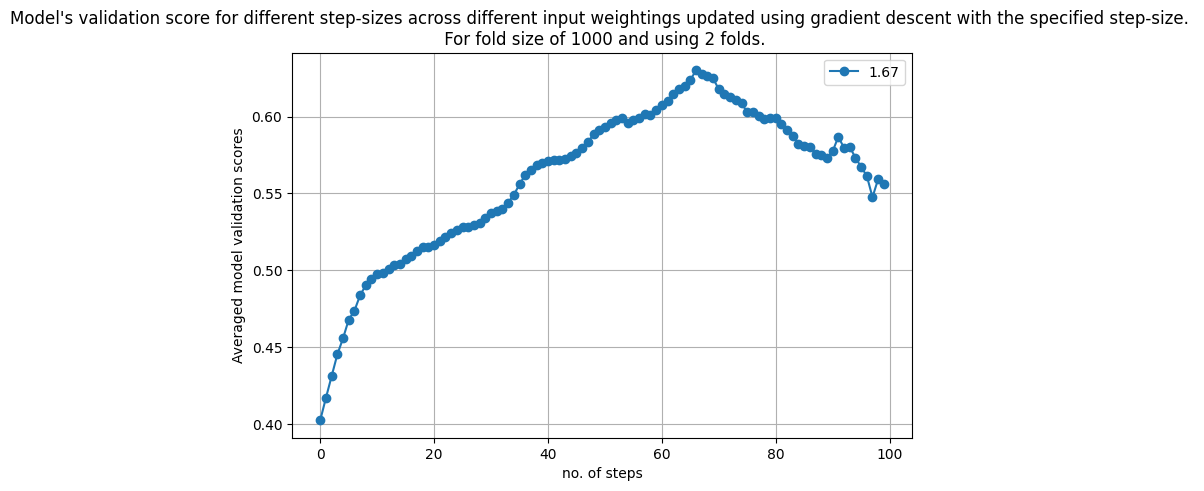

In [11]:
# Create a plot
plt.figure(figsize=(8, 5))

# Plot each key's values with a different color
for key, values in step_scores.items():
    plt.plot(values, marker='o', label=key)

# Add labels and legend
plt.xlabel("no. of steps")
plt.ylabel("Averaged model validation scores")
plt.title(f"Model's validation score for different step-sizes across different input weightings updated using gradient descent with the specified step-size. \n For fold size of 1000 and using {k} folds.")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

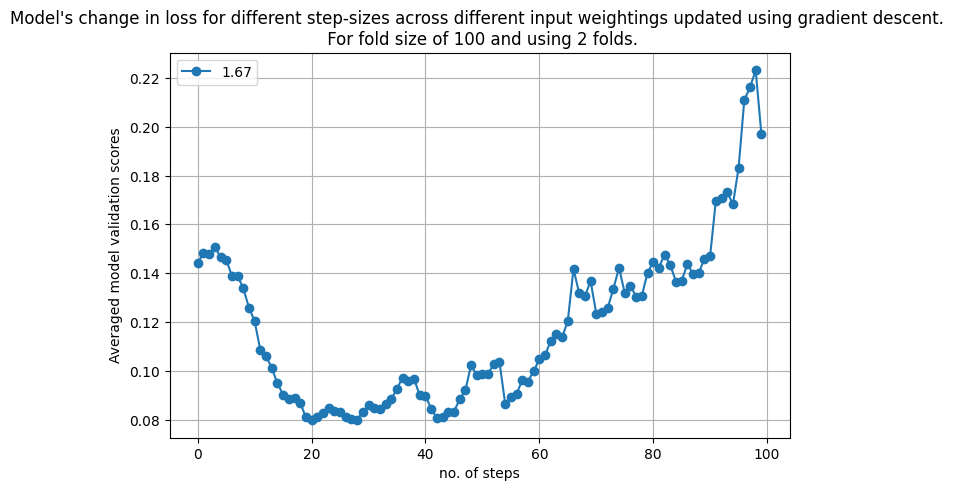

In [12]:
# Create a plot
plt.figure(figsize=(8, 5))

# Plot each key's values with a different color
for key, values in step_losses.items():
    plt.plot(values, marker='o', label=key)

# Add labels and legend
plt.xlabel("no. of steps")
plt.ylabel("Averaged model validation scores")
plt.title(f"Model's change in loss for different step-sizes across different input weightings updated using gradient descent. \n For fold size of 100 and using {k} folds.")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()